# Hourly Prediction of tomorrow's Revenue

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Data

### Revenue Data

In [2]:
#import raw revenue data
df_2016 = pd.read_csv("../../raw_data/orders2016.csv", sep=";")
df_2017 = pd.read_csv("../../raw_data/orders2017.csv", sep=";")
df_2018 = pd.read_csv("../../raw_data/orders2018.csv", sep=";")
df_2019 = pd.read_csv("../../raw_data/orders2019.csv", sep=";")
df_2020 = pd.read_csv("../../raw_data/orders2020.csv", sep=";")
df_2021 = pd.read_csv("../../raw_data/orders2021.csv", sep=";")
df_2022 = pd.read_csv("../../raw_data/orders2022.csv", sep=";")

df_list = [df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]


In [3]:
#create hourly revenue data

for df in df_list:
    df['time'] = df['time'].astype(str)

for i, df in enumerate(df_list):
    # Convert 'date' column to datetime dtype
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract the hour from 'time' column
    df['hour'] = df['time'].apply(lambda x: int(x.split(':')[0]))
    
    # Create combined datetime object using date and hour
    df['date_hour'] = df.apply(lambda row: datetime.datetime(row['date'].year, row['date'].month, row['date'].day, row['hour']), axis=1)
    
    df_list[i] = pd.DataFrame(df.groupby(by="date_hour")["item_price"].sum()/100)


In [5]:
#Concat all data in one dataframe, rename the columns for prophet

df = pd.concat(df_list, ignore_index=False)
df = df.rename(columns={"date_hour": "ds", "item_price": "y"})
df["ds"] = df.index
df = df.reset_index(drop=True)
df = df[["ds","y"]]

#turning the ds (date) column into datetime

df['ds']=pd.to_datetime(df['ds'])

df

,ds,y
0,2016-09-01 12:00:00,60.2
1,2016-09-01 13:00:00,114.0
2,2016-09-01 14:00:00,75.8
3,2016-09-01 15:00:00,41.8
4,2016-09-01 16:00:00,30.4
...,...,...
15521,2022-11-20 15:00:00,39.5
15522,2022-11-20 16:00:00,14.7
15523,2022-11-20 18:00:00,13.8
15524,2022-11-21 13:00:00,1.5


In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df['ds'], df['y'])
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Historic Weather Data

In [6]:
#merge hourly weather data to df
weather_df = pd.read_csv('../../feature_data/weather.csv')

weather_df = weather_df.drop(columns=['dt', 'timezone', 'city_name', 'lat', 'lon',
       'visibility', 'dew_point', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'wind_gust', 'rain_3h', 'snow_1h', 'snow_3h', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon','wind_deg'])

weather_df = weather_df.fillna(0)
weather_df['dt_iso'] = weather_df['dt_iso'].str[:19]
weather_df = weather_df.rename(columns={'dt_iso': 'ds'})
weather_df['ds']=pd.to_datetime(weather_df['ds'])

weather_df

,ds,temp,humidity,wind_speed,rain_1h,clouds_all
0,2016-09-01 00:00:00,16.78,64,1.03,0.00,0
1,2016-09-01 01:00:00,15.84,68,1.54,0.00,0
2,2016-09-01 02:00:00,15.77,64,1.03,0.00,0
3,2016-09-01 03:00:00,13.06,76,1.03,0.00,0
4,2016-09-01 04:00:00,12.05,80,0.51,0.00,0
...,...,...,...,...,...,...
56274,2022-11-22 19:00:00,1.58,92,4.12,0.25,100
56275,2022-11-22 20:00:00,1.59,92,3.60,0.25,100
56276,2022-11-22 21:00:00,1.55,89,3.60,0.00,100
56277,2022-11-22 22:00:00,1.61,89,3.13,0.00,20


In [7]:
merged_df = pd.merge(df,weather_df,how="left")
merged_df

,ds,y,temp,humidity,wind_speed,rain_1h,clouds_all
0,2016-09-01 12:00:00,60.2,25.90,35,6.70,0.00,0
1,2016-09-01 13:00:00,114.0,25.97,35,6.20,0.00,0
2,2016-09-01 14:00:00,75.8,26.04,35,4.63,0.00,0
3,2016-09-01 15:00:00,41.8,26.04,35,6.70,0.00,0
4,2016-09-01 16:00:00,30.4,25.09,39,5.14,0.00,0
...,...,...,...,...,...,...,...
15819,2022-11-20 15:00:00,39.5,0.83,85,4.63,0.00,75
15820,2022-11-20 16:00:00,14.7,0.65,85,4.02,0.25,100
15821,2022-11-20 18:00:00,13.8,0.13,85,3.13,0.00,75
15822,2022-11-21 13:00:00,1.5,-0.65,85,2.06,0.00,100


### Predicted Weather Data

In [8]:
weather_forecast_df = pd.read_csv("../../raw_data/weather_forecast_2018_2023.csv")
weather_forecast_df = weather_forecast_df.drop(columns=["forecast dt unixtime","convective","wind_deg","accumulated","hours","rate","slice dt unixtime","lat","lon","dew_point","snow_depth","snow","pressure","ground_pressure","ice","fr_rain"])

# Remove the ' UTC' part from the datetime strings
weather_forecast_df['forecast dt iso'] = weather_forecast_df['forecast dt iso'].str.replace(' UTC', '')
weather_forecast_df['slice dt iso'] = weather_forecast_df['slice dt iso'].str.replace(' UTC', '')


# Convert to datetime using the format with only %z for timezone
weather_forecast_df['forecast dt iso'] = pd.to_datetime(weather_forecast_df['forecast dt iso'], format='%Y-%m-%d %H:%M:%S')
weather_forecast_df['slice dt iso'] = pd.to_datetime(weather_forecast_df['slice dt iso'], format='%Y-%m-%d %H:%M:%S')

#Limiting the predictions to one point, e.g. midnight
#weather_predictions = weather_forecast_df[weather_forecast_df["forecast dt iso"].dt.time == pd.Timestamp("00:00:00+00:00").time()]
#weather_predictions['slice dt iso'] = pd.to_datetime(weather_predictions['slice dt iso'], format='%Y-%m-%d %H:%M:%S')

# rain_probability
weather_forecast_df['rain_probability'] = weather_forecast_df['rain'] * weather_forecast_df['probability']

#set the index 
weather_forecast_df.reset_index(drop=True, inplace=True)

weather_forecast_df = weather_forecast_df.drop(columns=['rain','probability'])
weather_forecast_df = weather_forecast_df.rename(columns={'temperature':'temp','rain_probability': 'rain_1h', 'slice dt iso':'ds', 'clouds':'clouds_all'})

## Basic Model (no regressors)

In [9]:
opening_hour = 12
closing_hour = 23

#CLEAN DATA (eliminate outliers + data outside of opening times)

cleaned_df = merged_df[(merged_df['ds'].dt.hour >= opening_hour) & (merged_df['ds'].dt.hour <= closing_hour)]
cleaned_df = cleaned_df[cleaned_df["y"]<=500]
cleaned_df =  cleaned_df.reset_index(drop=True)
cleaned_df

,ds,y,temp,humidity,wind_speed,rain_1h,clouds_all
0,2016-09-01 12:00:00,60.2,25.90,35,6.70,0.00,0
1,2016-09-01 13:00:00,114.0,25.97,35,6.20,0.00,0
2,2016-09-01 14:00:00,75.8,26.04,35,4.63,0.00,0
3,2016-09-01 15:00:00,41.8,26.04,35,6.70,0.00,0
4,2016-09-01 16:00:00,30.4,25.09,39,5.14,0.00,0
...,...,...,...,...,...,...,...
15652,2022-11-20 15:00:00,39.5,0.83,85,4.63,0.00,75
15653,2022-11-20 16:00:00,14.7,0.65,85,4.02,0.25,100
15654,2022-11-20 18:00:00,13.8,0.13,85,3.13,0.00,75
15655,2022-11-21 13:00:00,1.5,-0.65,85,2.06,0.00,100


In [10]:
#Setting variables
horizon = 13

#Splitting the data
from datetime import datetime as dt

split_date = "2022-08-01 13:00:00"
datetime_split = dt.strptime(split_date, "%Y-%m-%d %H:%M:%S")
index_split = cleaned_df[cleaned_df["ds"]==datetime_split].index[0]
df_train = cleaned_df.iloc[:index_split]
df_test = cleaned_df.iloc[index_split:]
y_test = pd.DataFrame(df_test["y"])

In [ ]:
#run FB Prophet model to forecast the next day hourly

from prophet import Prophet

#Instantiate
m = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)  # disable the built-in daily seasonality

#Adding regressors/features
# m.add_regressor("temp")
# m.add_regressor("humidity")
# m.add_regressor("wind_speed")
# m.add_regressor("rain_1h")
# m.add_regressor("snow_1h")
# m.add_regressor("clouds_all")

#Fitting the model
m = m.fit(df_train)

In [11]:
# Extract the last date from the dataframe
last_date = df_train["ds"].dt.date.iloc[-1]

# Construct the desired date range for the next day
next_day = last_date + pd.Timedelta(days=1)
desired_time_range = pd.date_range(start=f"{next_day} 12:00:00", end=f"{next_day} 22:00:00", freq='H')

# Append this to the original dataframe to get the future dataframe
future = df_train.append(pd.DataFrame({"ds": desired_time_range}), ignore_index=True)
future = future[["ds"]]

/tmp/ipykernel_966/1308331405.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future = df_train.append(pd.DataFrame({"ds": desired_time_range}), ignore_index=True)


In [ ]:
fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
one_day_forecast = fcst.tail(horizon)
one_day_forecast = one_day_forecast[one_day_forecast['ds'].dt.date == pd.to_datetime(split_date).date()]
one_day_forecast_slim = one_day_forecast[["ds","yhat_lower","yhat","yhat_upper"]]
prediction_forecast = one_day_forecast_slim.merge(df_test[['ds', 'y']], on='ds', how='left')
prediction_forecast.rename(columns={'y': 'y_true'}, inplace=True)
prediction_forecast = prediction_forecast.fillna(0)
prediction_forecast["error"]=abs(prediction_forecast["yhat"]-prediction_forecast["y_true"])
prediction_forecast

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark background with neon-like color palette
plt.style.use('dark_background')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Plot y_true for comparison
ax.plot(prediction_forecast['ds'], prediction_forecast['y_true'], label='Actual (y_true)', color='limegreen', linewidth=2, linestyle='--', alpha=0.8)

# Plot yhat as the main prediction line
ax.plot(prediction_forecast['ds'], prediction_forecast['yhat'], label='Prediction (yhat)', color='dodgerblue', linewidth=3)

# Fill the area between yhat_lower and yhat_upper for confidence interval
ax.fill_between(prediction_forecast['ds'], prediction_forecast['yhat_lower'], prediction_forecast['yhat_upper'], color='skyblue', alpha=0.3)

# Fine grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove top and right spines for aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

# Set labels, title, and legend with a futuristic font (if available)
font_title = {'family': 'sans-serif', 'color':  'white', 'weight': 'bold', 'size': 20}
font_labels = {'family': 'sans-serif', 'color':  'white', 'weight': 'normal', 'size': 14}
ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Value', fontdict=font_labels)
ax.set_title('Prediction vs Actual', fontdict=font_title)
ax.legend()
ax.set_xticks(prediction_forecast['ds'])
ax.set_xticklabels([dt.strftime('%H:%M:%S') for dt in prediction_forecast['ds']], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
#MAE
from sklearn.metrics import mean_absolute_error

y_true = prediction_forecast["y_true"]
y_pred = prediction_forecast["yhat"]

mae = mean_absolute_error(y_true, y_pred)

mae

In [ ]:
#MAPE
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_true, y_pred)
mape

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly


plot_components_plotly(m, fcst)

## Regressor Model

In [ ]:
split_date = "2022-08-01 13:00:00"
datetime_split = dt.strptime(split_date, "%Y-%m-%d %H:%M:%S")
index_split = cleaned_df[cleaned_df["ds"]==datetime_split].index[0]
df_train = cleaned_df.iloc[:index_split]
df_test = cleaned_df.iloc[index_split:]
y_test = pd.DataFrame(df_test["y"])

In [12]:
# Define the date for which you want predictions (at midnight)
weather_split_date = pd.Timestamp('2022-07-31 00:00:00+00:00')

# Filter the dataframe based on criteria (weather prediction from midnight the day before, for the next day between 12 and 22)
filtered_predictions = weather_forecast_df[
    (weather_forecast_df['forecast dt iso'] == weather_split_date) &
    (weather_forecast_df['ds'].dt.date == (weather_split_date + pd.Timedelta(days=1)).date()) &
    (weather_forecast_df['ds'].dt.hour >= 12) & (weather_forecast_df['ds'].dt.hour <= 22)
]

filtered_predictions

,forecast dt iso,ds,temp,humidity,clouds_all,wind_speed,rain_1h
2382540,2022-07-31 00:00:00+00:00,2022-08-01 12:00:00+00:00,24.03,56.00,87.0,4.37,0.310
2382541,2022-07-31 00:00:00+00:00,2022-08-01 13:00:00+00:00,24.65,51.47,88.0,4.38,0.161
2382542,2022-07-31 00:00:00+00:00,2022-08-01 14:00:00+00:00,25.11,47.86,90.0,4.46,0.034
2382543,2022-07-31 00:00:00+00:00,2022-08-01 15:00:00+00:00,25.19,46.30,92.0,4.54,0.000
2382544,2022-07-31 00:00:00+00:00,2022-08-01 16:00:00+00:00,24.75,47.61,93.0,4.51,0.000
2382545,2022-07-31 00:00:00+00:00,2022-08-01 17:00:00+00:00,23.89,51.16,93.0,4.33,0.000
2382546,2022-07-31 00:00:00+00:00,2022-08-01 18:00:00+00:00,22.80,56.00,94.0,3.95,0.000
2382547,2022-07-31 00:00:00+00:00,2022-08-01 19:00:00+00:00,21.65,61.20,96.0,3.35,0.000
2382548,2022-07-31 00:00:00+00:00,2022-08-01 20:00:00+00:00,20.55,66.08,99.0,2.69,0.000
2382549,2022-07-31 00:00:00+00:00,2022-08-01 21:00:00+00:00,19.59,70.00,100.0,2.15,0.000


In [ ]:
from prophet import Prophet

#Instantiate
m = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)

#Adding regressors/features
m.add_regressor("temp")
m.add_regressor("humidity")
m.add_regressor("wind_speed")
m.add_regressor("rain_1h")
m.add_regressor("clouds_all")

#Fitting the model
m = m.fit(df_train)

In [ ]:
#Creating future dataframe
# Extract the last date from the dataframe
last_date = df_train["ds"].dt.date.iloc[-1]

# Construct the desired date range for the next day
next_day = last_date + pd.Timedelta(days=1)
desired_time_range = pd.date_range(start=f"{next_day} 12:00:00", end=f"{next_day} 22:00:00", freq='H')

# Append this to the original dataframe to get the future dataframe
future = df_train.append(pd.DataFrame({"ds": desired_time_range}), ignore_index=True)
future = future[["ds"]]

#Updating weather data with predicted weather data
future['ds'] = future['ds'].dt.tz_localize(None)
filtered_predictions['ds'] = filtered_predictions['ds'].dt.tz_localize(None)

future = pd.merge(future,filtered_predictions,how="left")
future = future.tail(11)
future = future.drop(columns=['forecast dt iso']).reset_index(drop=True)

In [ ]:
fcst = m.predict(future)

In [ ]:
one_day_forecast = fcst.tail(horizon)
one_day_forecast = one_day_forecast[one_day_forecast['ds'].dt.date == pd.to_datetime(split_date).date()]
one_day_forecast_slim = one_day_forecast[["ds","yhat_lower","yhat","yhat_upper"]]
prediction_forecast = one_day_forecast_slim.merge(df_test[['ds', 'y']], on='ds', how='left')
prediction_forecast.rename(columns={'y': 'y_true'}, inplace=True)
prediction_forecast = prediction_forecast.fillna(0)
prediction_forecast["error"]=abs(prediction_forecast["yhat"]-prediction_forecast["y_true"])
prediction_forecast

In [ ]:
from prophet.utilities import regressor_coefficients

coefficients = regressor_coefficients(m)
coefficients

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark background with neon-like color palette
plt.style.use('dark_background')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Plot y_true for comparison
ax.plot(prediction_forecast['ds'], prediction_forecast['y_true'], label='Actual (y_true)', color='limegreen', linewidth=2, linestyle='--', alpha=0.8)

# Plot yhat as the main prediction line
ax.plot(prediction_forecast['ds'], prediction_forecast['yhat'], label='Prediction (yhat)', color='dodgerblue', linewidth=3)

# Fill the area between yhat_lower and yhat_upper for confidence interval
ax.fill_between(prediction_forecast['ds'], prediction_forecast['yhat_lower'], prediction_forecast['yhat_upper'], color='skyblue', alpha=0.3)

# Fine grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove top and right spines for aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

# Set labels, title, and legend with a futuristic font (if available)
font_title = {'family': 'sans-serif', 'color':  'white', 'weight': 'bold', 'size': 20}
font_labels = {'family': 'sans-serif', 'color':  'white', 'weight': 'normal', 'size': 14}
ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Value', fontdict=font_labels)
ax.set_title('Prediction vs Actual', fontdict=font_title)
ax.legend()
ax.set_xticks(prediction_forecast['ds'])
ax.set_xticklabels([dt.strftime('%H:%M:%S') for dt in prediction_forecast['ds']], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
#MAE
from sklearn.metrics import mean_absolute_error

y_true = prediction_forecast["y_true"]
y_pred = prediction_forecast["yhat"]

mae = mean_absolute_error(y_true, y_pred)

mae

## Logistic Regressor model

In [ ]:
# since we experienced negative predictions, we want to use a logistic growth model including a floor and a cap

df_train["floor"] = 0
future["floor"] = 0
df_train["cap"] = 500
future["cap"] = 500

In [17]:
from prophet import Prophet

m = Prophet(growth='logistic', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)

#Adding regressors/features
m.add_regressor("temp")
m.add_regressor("humidity")
m.add_regressor("wind_speed")
m.add_regressor("rain_1h")
m.add_regressor("clouds_all")

m.fit(df_train)

16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
fcst = m.predict(future)

In [19]:
one_day_forecast = fcst.tail(horizon)
one_day_forecast = one_day_forecast[one_day_forecast['ds'].dt.date == pd.to_datetime(split_date).date()]
one_day_forecast_slim = one_day_forecast[["ds","yhat_lower","yhat","yhat_upper"]]
prediction_forecast = one_day_forecast_slim.merge(df_test[['ds', 'y']], on='ds', how='left')
prediction_forecast.rename(columns={'y': 'y_true'}, inplace=True)
prediction_forecast = prediction_forecast.fillna(0)
prediction_forecast["error"]=abs(prediction_forecast["yhat"]-prediction_forecast["y_true"])
prediction_forecast

,ds,yhat_lower,yhat,yhat_upper,y_true,error
0,2022-08-01 12:00:00,-53.085470,7.157983,62.617452,0.0,7.157983
1,2022-08-01 13:00:00,-18.951763,36.746755,94.560839,14.0,22.746755
2,2022-08-01 14:00:00,6.109408,58.855554,120.477325,21.6,37.255554
3,2022-08-01 15:00:00,23.512340,76.276288,129.093898,78.7,2.423712
4,2022-08-01 16:00:00,21.689734,80.133151,137.577492,20.7,59.433151
5,2022-08-01 17:00:00,12.816077,68.995826,127.405212,76.3,7.304174
6,2022-08-01 18:00:00,-3.633424,56.160851,111.607462,43.8,12.360851
7,2022-08-01 19:00:00,-5.771186,54.184344,108.194939,30.6,23.584344
8,2022-08-01 20:00:00,-6.596579,54.575188,113.481345,95.4,40.824812
9,2022-08-01 21:00:00,-21.365812,33.483608,89.189311,64.8,31.316392


In [20]:
#MAE
from sklearn.metrics import mean_absolute_error

y_true = prediction_forecast["y_true"]
y_pred = prediction_forecast["yhat"]

mae = mean_absolute_error(y_true, y_pred)

mae

23.61874374698086

In [22]:
#since we still predict negative values we will set those to 0
prediction_forecast['yhat'] = prediction_forecast['yhat'].apply(lambda x: 0 if x < 0 else x)

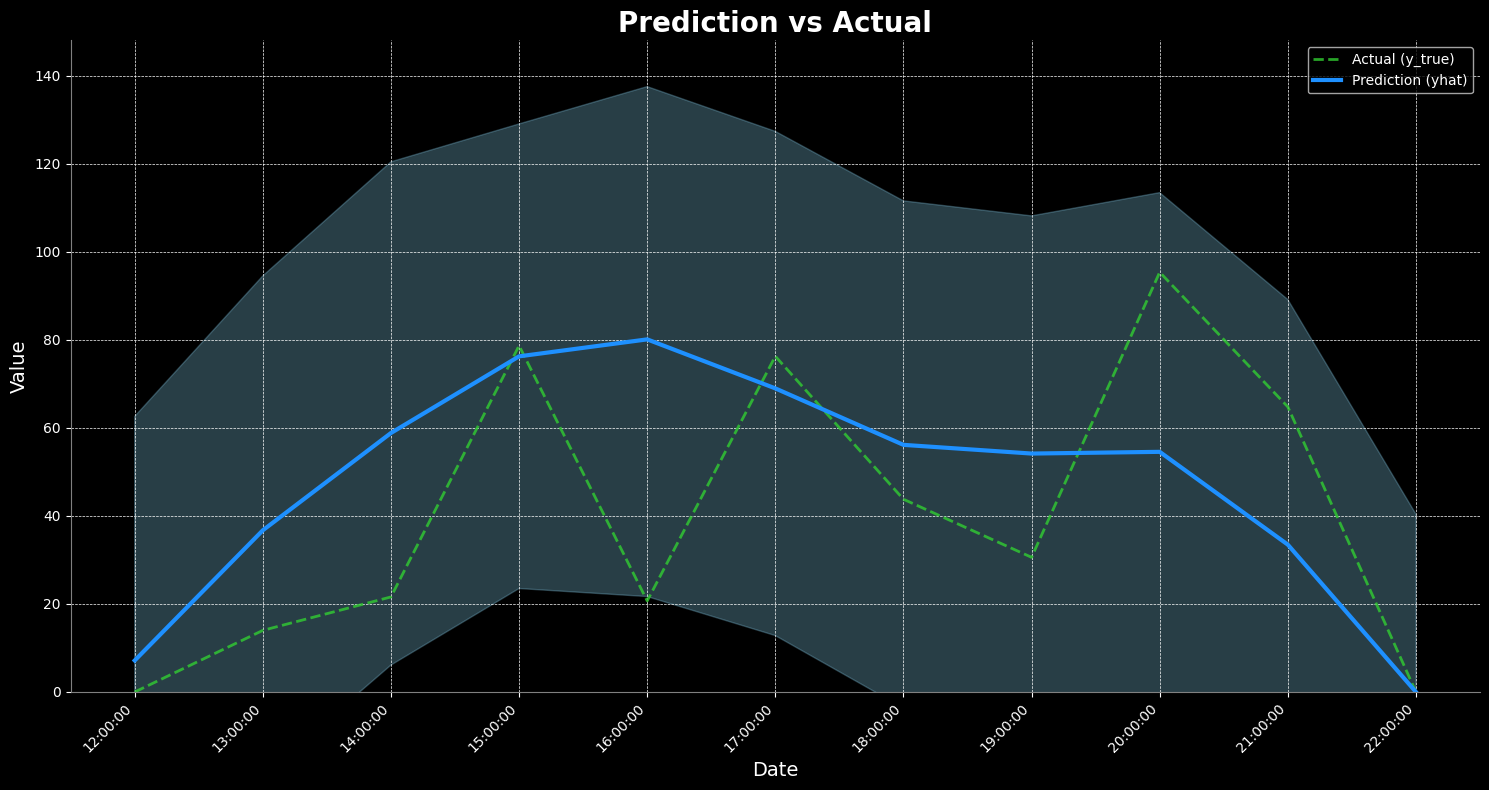

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a dark background with neon-like color palette
plt.style.use('dark_background')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(15, 8))

# Plot y_true for comparison
ax.plot(prediction_forecast['ds'], prediction_forecast['y_true'], label='Actual (y_true)', color='limegreen', linewidth=2, linestyle='--', alpha=0.8)

# Plot yhat as the main prediction line
ax.plot(prediction_forecast['ds'], prediction_forecast['yhat'], label='Prediction (yhat)', color='dodgerblue', linewidth=3)

# Fill the area between yhat_lower and yhat_upper for confidence interval
ax.fill_between(prediction_forecast['ds'], prediction_forecast['yhat_lower'], prediction_forecast['yhat_upper'], color='skyblue', alpha=0.3)

# Fine grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove top and right spines for aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')

# Set labels, title, and legend with a futuristic font (if available)
font_title = {'family': 'sans-serif', 'color':  'white', 'weight': 'bold', 'size': 20}
font_labels = {'family': 'sans-serif', 'color':  'white', 'weight': 'normal', 'size': 14}
ax.set_xlabel('Date', fontdict=font_labels)
ax.set_ylabel('Value', fontdict=font_labels)
ax.set_title('Prediction vs Actual', fontdict=font_title)
ax.legend()
ax.set_xticks(prediction_forecast['ds'])
ax.set_xticklabels([dt.strftime('%H:%M:%S') for dt in prediction_forecast['ds']], rotation=45, ha='right')
ax.set_ylim(bottom=0) 

plt.tight_layout()
plt.show()

# Production code

In [2]:
#IMPORTS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from prophet import Prophet
from datetime import datetime as dt

In [5]:
#LOADING DATA

#import raw revenue data
df_2016 = pd.read_csv("../../raw_data/orders2016.csv", sep=";")
df_2017 = pd.read_csv("../../raw_data/orders2017.csv", sep=";")
df_2018 = pd.read_csv("../../raw_data/orders2018.csv", sep=";")
df_2019 = pd.read_csv("../../raw_data/orders2019.csv", sep=";")
df_2020 = pd.read_csv("../../raw_data/orders2020.csv", sep=";")
df_2021 = pd.read_csv("../../raw_data/orders2021.csv", sep=";")
df_2022 = pd.read_csv("../../raw_data/orders2022.csv", sep=";")

df_list = [df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]

#create hourly revenue data
for df in df_list:
    df['time'] = df['time'].astype(str)

for i, df in enumerate(df_list):
    # Convert 'date' column to datetime dtype
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract the hour from 'time' column
    df['hour'] = df['time'].apply(lambda x: int(x.split(':')[0]))
    
    # Create combined datetime object using date and hour
    df['date_hour'] = df.apply(lambda row: datetime.datetime(row['date'].year, row['date'].month, row['date'].day, row['hour']), axis=1)
    
    df_list[i] = pd.DataFrame(df.groupby(by="date_hour")["item_price"].sum()/100)
    
#Concat all data in one dataframe, rename the columns for prophet
df = pd.concat(df_list, ignore_index=False)
df = df.rename(columns={"date_hour": "ds", "item_price": "y"})
df["ds"] = df.index
df = df.reset_index(drop=True)
df = df[["ds","y"]]

#turning the ds (date) column into datetime
df['ds']=pd.to_datetime(df['ds'])

#LOADING HISTORIC WEATHER DATA
weather_df = pd.read_csv('../../feature_data/weather.csv')

weather_df = weather_df.drop(columns=['dt', 'timezone', 'city_name', 'lat', 'lon',
       'visibility', 'dew_point', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'wind_gust', 'rain_3h', 'snow_1h', 'snow_3h', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon','wind_deg'])

weather_df = weather_df.fillna(0)
weather_df['dt_iso'] = weather_df['dt_iso'].str[:19]
weather_df = weather_df.rename(columns={'dt_iso': 'ds'})
weather_df['ds']=pd.to_datetime(weather_df['ds'])

#MERGING features with df
merged_df = pd.merge(df,weather_df,how="left")

#LOADING AND PREPROCESSING WEATHER PREDICTIONS

weather_forecast_df = pd.read_csv("../../raw_data/weather_forecast_2018_2023.csv")
weather_forecast_df = weather_forecast_df.drop(columns=["forecast dt unixtime","convective","wind_deg","accumulated","hours","rate","slice dt unixtime","lat","lon","dew_point","snow_depth","snow","pressure","ground_pressure","ice","fr_rain"])

# Remove the ' UTC' part from the datetime strings
weather_forecast_df['forecast dt iso'] = weather_forecast_df['forecast dt iso'].str.replace(' UTC', '')
weather_forecast_df['slice dt iso'] = weather_forecast_df['slice dt iso'].str.replace(' UTC', '')

# Convert to datetime using the format with only %z for timezone
weather_forecast_df['forecast dt iso'] = pd.to_datetime(weather_forecast_df['forecast dt iso'], format='%Y-%m-%d %H:%M:%S')
weather_forecast_df['slice dt iso'] = pd.to_datetime(weather_forecast_df['slice dt iso'], format='%Y-%m-%d %H:%M:%S')

# rain_probability
weather_forecast_df['rain_probability'] = weather_forecast_df['rain'] * weather_forecast_df['probability']

#set the index 
weather_forecast_df.reset_index(drop=True, inplace=True)

weather_forecast_df = weather_forecast_df.drop(columns=['rain','probability'])
weather_forecast_df = weather_forecast_df.rename(columns={'temperature':'temp','rain_probability': 'rain_1h', 'slice dt iso':'ds', 'clouds':'clouds_all'})

#SETTING VARIABLES
horizon = 13
opening_hour = 12
closing_hour = 23

#CLEANING DATA
cleaned_df = merged_df[(merged_df['ds'].dt.hour >= opening_hour) & (merged_df['ds'].dt.hour <= closing_hour)]
cleaned_df = cleaned_df[cleaned_df["y"]<=500]
cleaned_df =  cleaned_df.reset_index(drop=True)

#SPLITTING DATA
split_date = "2022-08-01 13:00:00"
datetime_split = dt.strptime(split_date, "%Y-%m-%d %H:%M:%S")
index_split = cleaned_df[cleaned_df["ds"]==datetime_split].index[0]
df_train = cleaned_df.iloc[:index_split]
df_test = cleaned_df.iloc[index_split:]
y_test = pd.DataFrame(df_test["y"])

# since we experienced negative predictions, we want to use a logistic growth model including a floor and a cap

df_train["floor"] = 0
df_train["cap"] = 500

# Define the date for which you want predictions (at midnight)
weather_split_date = pd.Timestamp('2022-07-31 00:00:00+00:00')

# Filter the dataframe based on criteria (weather prediction from midnight the day before, for the next day between 12 and 22)
filtered_predictions = weather_forecast_df[
    (weather_forecast_df['forecast dt iso'] == weather_split_date) &
    (weather_forecast_df['ds'].dt.date == (weather_split_date + pd.Timedelta(days=1)).date()) &
    (weather_forecast_df['ds'].dt.hour >= 12) & (weather_forecast_df['ds'].dt.hour <= 22)
]

#INSTANTIATING THE MODEL

from prophet import Prophet

m = Prophet(growth='logistic', changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.1)

#Adding regressors/features
m.add_regressor("temp")
m.add_regressor("humidity")
m.add_regressor("wind_speed")
m.add_regressor("rain_1h")
m.add_regressor("clouds_all")

m.fit(df_train)

#Creating future dataframe
# Extract the last date from the dataframe
last_date = df_train["ds"].dt.date.iloc[-1]

# Construct the desired date range for the next day
next_day = last_date + pd.Timedelta(days=1)
desired_time_range = pd.date_range(start=f"{next_day} 12:00:00", end=f"{next_day} 22:00:00", freq='H')

# Append this to the original dataframe to get the future dataframe
future = df_train.append(pd.DataFrame({"ds": desired_time_range}), ignore_index=True)
future = future[["ds"]]

#Updating weather data with predicted weather data
future['ds'] = future['ds'].dt.tz_localize(None)
filtered_predictions['ds'] = filtered_predictions['ds'].dt.tz_localize(None)

future = pd.merge(future,filtered_predictions,how="left")
future["floor"] = 0
future["cap"] = 500
future = future.tail(11)
future = future.drop(columns=['forecast dt iso']).reset_index(drop=True)

#PREDICTING

fcst = m.predict(future)

one_day_forecast = fcst.tail(horizon)
one_day_forecast = one_day_forecast[one_day_forecast['ds'].dt.date == pd.to_datetime(split_date).date()]
one_day_forecast_slim = one_day_forecast[["ds","yhat_lower","yhat","yhat_upper"]]
prediction_forecast = one_day_forecast_slim.merge(df_test[['ds', 'y']], on='ds', how='left')
prediction_forecast.rename(columns={'y': 'y_true'}, inplace=True)
prediction_forecast = prediction_forecast.fillna(0)
prediction_forecast["error"]=abs(prediction_forecast["yhat"]-prediction_forecast["y_true"])
prediction_forecast["yhat"] = prediction_forecast["yhat"].apply(lambda x: 0 if x < 0 else x)

/tmp/ipykernel_3062/2653833207.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["floor"] = 0
/tmp/ipykernel_3062/2653833207.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["cap"] = 500
14:15:10 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_3062/2653833207.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future = df_t

,ds,yhat_lower,yhat,yhat_upper,y_true,error
0,2022-08-01 12:00:00,-49.268109,7.157983,63.966947,0.0,7.157983
1,2022-08-01 13:00:00,-22.219353,36.746755,92.448390,14.0,22.746755
2,2022-08-01 14:00:00,-1.239821,58.855554,118.852272,21.6,37.255554
3,2022-08-01 15:00:00,20.265878,76.276288,130.718059,78.7,2.423712
4,2022-08-01 16:00:00,21.843188,80.133151,131.552414,20.7,59.433151
5,2022-08-01 17:00:00,15.597991,68.995826,126.691860,76.3,7.304174
6,2022-08-01 18:00:00,-3.248951,56.160851,113.278036,43.8,12.360851
7,2022-08-01 19:00:00,-0.690011,54.184344,108.620965,30.6,23.584344
8,2022-08-01 20:00:00,-3.922935,54.575188,107.382215,95.4,40.824812
9,2022-08-01 21:00:00,-22.062682,33.483608,85.344696,64.8,31.316392
